In [32]:
#data manipulation
import pandas as pd
import numpy as np
#plotting library
import matplotlib.pyplot as plt  
#AI related libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics

#this one are just legacy imports right now
import tensorflow as tf
import joblib
import time
import os
from datetime import date
import csv

In [96]:
#loading dataset
dataset = pd.read_csv("treeCovDataset/covtype.csv")
dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


# Discovering and cleaning data

In [44]:
#this function checks if any field in dataset is empty and return True or False
def checkIfDatasetIsClean(dataset, verbose = 0):
    flag = False
    fields = []
    for i in dataset.isnull().any():
        if i == False:
            pass
        else:
            flag = True
    if flag:
        if verbose >= 1:
            print("There are null fields in dataset")
        return False
    else:
        if verbose >= 1:
            print("Dataset is clean")
        return True

In [45]:
checkIfDatasetIsClean(dataset)

True

<AxesSubplot:>

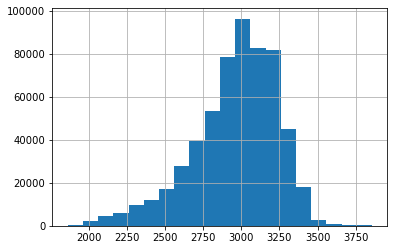

In [109]:
dataset.Elevation.hist(bins=20)

<AxesSubplot:>

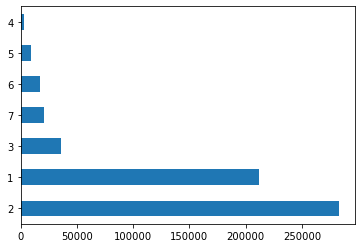

In [111]:
dataset.Cover_Type.value_counts().plot(kind='barh')

# Preparing data for Decision tree and linear regression

In [47]:
# selecting only numeric data from dataset
# if there are non numerical data in dataset I would need to 
# sumpliment them with numerical data I would need to introduce vocabulary
# and convert all data 
# example code for that is bellow:
#  code from: https://www.tensorflow.org/tutorials/estimator/linear
#     CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
#                        'embark_town', 'alone']
#     NUMERIC_COLUMNS = ['age', 'fare']

#     feature_columns = []
#     for feature_name in CATEGORICAL_COLUMNS:
#       vocabulary = dftrain[feature_name].unique()
#       feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

#     for feature_name in NUMERIC_COLUMNS:
#       feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

#this one selects only numerical data from dataset
# dataset = dataset.select_dtypes(include=['int', 'float'])
# splitting data into feature colums and label column.

X = dataset.drop(columns=["Cover_Type"]) # feature set
y = dataset['Cover_Type'] # label set

In [54]:
# splitting data in training and testing, introducing random_state here to keep dataset same for 
# multiple runs to gain same results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
# creating decision tree model
modelDT = DecisionTreeClassifier()
modelDT.fit(X_train,y_train)
# creatinf linear regresion model
modelLR = LinearRegression()  
modelLR.fit(X_train, y_train)

LinearRegression()

In [56]:
#predicting and evaluating decision tree
predictionDT = modelDT.predict(X_test)
scoreDT = accuracy_score(y_test, predictionDT)

print("accuracy score of decision tree model: " + str(scoreDT))

accuracy score of decision tree model: 0.9396315069318348


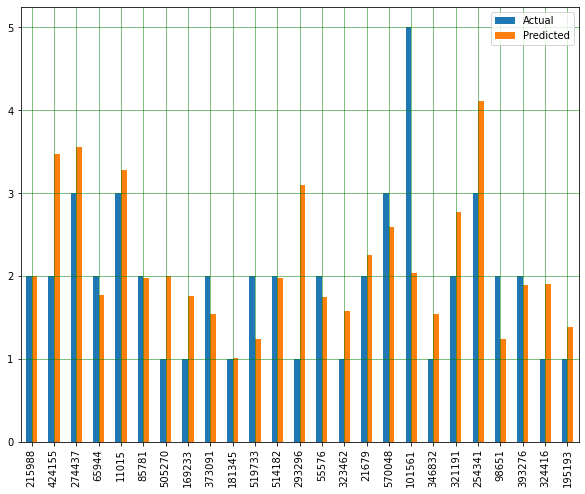

Mean: 2.052847172620328
Root Mean Squared Error: 1.148463385730019


In [57]:
# PRedicting and evaluating linear regresion algorithm
y_predLR = modelLR.predict(X_test)
df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_predLR})
df_head = df_compare.head(25)
df_head.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean:', np.mean(y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predLR)))

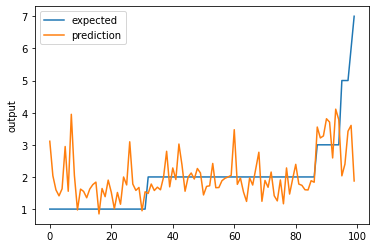

In [58]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
chart_regression(y_predLR[:100].flatten(),y_test[:100],sort=True) 

In [89]:
from collections import defaultdict
#this funcion find out best split for decision tree and linear regresion
def findOptimalSplitOfData(X, y, verbose = 0, minSize = 10, maxSize= 94, step = 2, models = ["decisionTree","linear regresion"]):
    if verbose == 1:
        print(f"Running test for {models}. \nMinimum test size: {minSize}%\nMaximum test size: {maxSize}%")
    DTscore = defaultdict(list)
    LRmean = defaultdict(list)
    LRsqrterror = defaultdict(list)
    for testSize in range(minSize, maxSize, step):
        listDT= []
        listLRmean = []
        listLRsqrt = []
        for randomState in range (0,11):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize/100, random_state=randomState)
            #decision tree calculation
            modelDT = DecisionTreeClassifier()
            modelDT.fit(X_train,y_train)
            predictionDT = modelDT.predict(X_test)
            scoreDT = accuracy_score(y_test, predictionDT)
            listDT.append(scoreDT)
            #linear regresion calculation
            modelLR = LinearRegression()  
            modelLR.fit(X_train, y_train)
            y_predLR = modelLR.predict(X_test)
            listLRmean.append(np.mean(y_test))
            listLRsqrt.append(np.sqrt(metrics.mean_squared_error(y_test, y_predLR)))
            
            
        DTscore[testSize].append(( sum(listDT)/ len(listDT) ) )
        LRmean[testSize].append(sum(listLRmean)/ len(listLRmean))
        LRsqrterror[testSize]. append(sum(listLRsqrt)/ len(listLRsqrt))
        
    print(f"Best split for decision tree is: {max(DTscore, key=DTscore.get)}")  
    print(f"Best split for linear regresion is (sqrtError): {min(LRsqrterror, key = LRsqrterror.get)}")
    print(f"Best split for linear regresion is (meanError): {min(LRmean, key = LRmean.get)}")
    return [DTscore, LRmean, LRsqrterror]
        
        

In [90]:
print (findOptimalSplitOfData(X, y, verbose=1))

Running test for ['decisionTree', 'linear regresion']. 
Minimum test size: 10%
Maximum test size: 94%
Best split for decision tree is: 10
Best split for linear regresion is (sqrtError): 40
Best split for linear regresion is (meanError): 50
[defaultdict(<class 'list'>, {10: [0.9427621017583497], 12: [0.9422863788917545], 14: [0.941668287209336], 16: [0.9404742113590892], 18: [0.9399772081852344], 20: [0.9393631677479771], 22: [0.9384624903897648], 24: [0.937604351859639], 26: [0.9368852695786974], 28: [0.9360651212277677], 30: [0.9353073835472402], 32: [0.9342204341558916], 34: [0.9332414478634327], 36: [0.9318576243635409], 38: [0.9310159822287004], 40: [0.9297668059871973], 42: [0.9286074583706803], 44: [0.9271304140028861], 46: [0.9257722813431358], 48: [0.924342823688793], 50: [0.9233037277277328], 52: [0.9219235619458043], 54: [0.920200613290906], 56: [0.9183266336726891], 58: [0.9165157976150685], 60: [0.914452231837375], 62: [0.9122015652712879], 64: [0.9100805607765442], 66: [0.

# Neuron network training  

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [97]:
# dataset = pd.read_csv("/content/drive/MyDrive/treeCovDataset/covtype.csv")
dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [93]:
#This code is from lecture slides without any change
# Convert a Pandas dataframe to the X,y inputs that Keras needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print("returning for classification")
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    print("Returning for regression")
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)


In [98]:
#dataset = dataset.select_dtypes(include=['int', 'float'])
X,y = to_xy(dataset, "Cover_Type")


returning for classification


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [ ]:
# First model of NN
modelNN = Sequential()
modelNN.add(Dense(32, input_shape=X[1].shape, activation='sigmoid')) # Hidden 1
modelNN.add(Dense(7)) # Output
modelNN.summary() #note, only works if input shape specified, or Input layer given
modelNN.compile(loss='mean_squared_error', optimizer='adam')
modelNN.fit(X_train,y_train,verbose=2,epochs=10)
pred = modelNN.predict(X_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print(f"Final score (RMSE): {score}")
modelNN.summary()

# Optimalizing and results
Cells bellow take while to execute.
Execution was run on google collab with Google RAM and CPU
share link to notebook: https://colab.research.google.com/drive/1NhyWhTXXufcPzz_NN0g-3GFhmzOw1On1?usp=sharing

In [ ]:
from collections import defaultdict
# Ole layer with sigmoid activation function
def NNoptimalResultwithOneLayer(X, y, minNodes = 32, maxNodes = 650, step = 32):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
  NNscore = defaultdict(list)
  for nodes in range(minNodes, maxNodes, step):
    modelNN = Sequential()
    modelNN.add(Dense(nodes, input_shape=X[1].shape, activation='sigmoid')) # Hidden 1
    modelNN.add(Dense(7)) # Output
    modelNN.compile(loss='mean_squared_error', optimizer='adam')
    modelNN.fit(X_train,y_train,epochs=10, verbose=0)
    pred = modelNN.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print(f"For {nodes} - Final score (RMSE): {score}")
    NNscore[nodes].append(score)
  print(f"The most eficient is to use: {min(NNscore, key=NNscore.get)} nodes")
  return NNscore
NNoptimalResultwithOneLayer(X,y)

In [ ]:
from collections import defaultdict
# One layer with RELU activation function
def NNoptimalResultwithOneLayerRELU(X, y, minNodes = 32, maxNodes = 650, step = 32):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
  NNscore = defaultdict(list)
  for nodes in range(minNodes, maxNodes, step):
    modelNN = Sequential()
    modelNN.add(Dense(nodes, input_shape=X[1].shape, activation='relu')) # Hidden 1
    modelNN.add(Dense(7)) # Output
    modelNN.compile(loss='mean_squared_error', optimizer='adam')
    modelNN.fit(X_train,y_train,epochs=10)
    pred = modelNN.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print(f"For {nodes} - Final score (RMSE): {score}")
    NNscore[nodes].append(score)
  print(f"The most eficient is to use: {min(NNscore, key=NNscore.get)} nodes")
  return NNscore
NNoptimalResultwithOneLayerRELU(X,y)

In [ ]:
from collections import defaultdict
# Two layers with RELU activation function
def NNoptimalResultwithTwoLayerRELU(X, y, minNodes = 32, maxNodes = 650, step = 32):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
  NNscore = defaultdict(list)
  for nodes in range(minNodes, maxNodes, step):
    modelNN = Sequential()
    modelNN.add(Dense(nodes, input_shape=X[1].shape, activation='relu')) # Hidden 1
    modelNN.add(Dense(nodes, input_shape=X[1].shape, activation='relu')) # Hidden 2
    modelNN.add(Dense(7)) # Output
    modelNN.compile(loss='mean_squared_error', optimizer='adam')
    modelNN.fit(X_train,y_train,epochs=10)
    pred = modelNN.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print(f"For {nodes} - Final score (RMSE): {score}")
    NNscore[nodes].append(score)
  print(f"The most eficient is to use: {min(NNscore, key=NNscore.get)} nodes")
  return NNscore
NNoptimalResultwithTwoLayerRELU(X,y)

In [ ]:
from collections import defaultdict
#Two layer with sigmoid activation function
def NNoptimalResultwithTwoLayer(X, y, minNodes = 32, maxNodes = 650, step = 32):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
  NNscore = defaultdict(list)
  for nodes in range(minNodes, maxNodes, step):
    modelNN = Sequential()
    modelNN.add(Dense(nodes, input_shape=X[1].shape, activation='sigmoid')) # Hidden 1
    modelNN.add(Dense(nodes, input_shape=X[1].shape, activation='sigmoid')) # Hidden 2
    modelNN.add(Dense(7)) # Output
    modelNN.compile(loss='mean_squared_error', optimizer='adam')
    modelNN.fit(X_train,y_train,epochs=10)
    pred = modelNN.predict(X_test)
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print(f"For {nodes} - Final score (RMSE): {score}")
    NNscore[nodes].append(score)
  print(f"The most eficient is to use: {min(NNscore, key=NNscore.get)} nodes")
  return NNscore
NNoptimalResultwithTwoLayer(X,y)